In [147]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator ##
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout,MaxPooling2D

import pickle

####  PARAMETERS 


In [180]:
path = 'data'
taille_image=32
testRatio = 0.2
valRatio = 0.2
imageDimensions= (taille_image,taille_image,3)
batchSizeVal= 50
epochsVal = 10
stepsPerEpochVal = 550

#### IMPORTING DATA/IMAGES FROM FOLDERS 

In [181]:
count = 0
images = []     # LIST CONTAINING ALL THE IMAGES 
classNo = []    # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES 
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)
print("Importing Classes .......")
for x in range (0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(32,32))
        images.append(curImg)
        classNo.append(x)
    print(x,end= " ")
print(" ")
print("Total Images in Images List = ",len(images))
print("Total IDS in classNo List= ",len(classNo))

Total Classes Detected: 10
Importing Classes .......
0 1 2 3 4 5 6 7 8 9  
Total Images in Images List =  43680
Total IDS in classNo List=  43680


#### CONVERT TO NUMPY ARRAY 

In [183]:
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)


(43680, 32, 32, 3)


#### SPLITTING THE DATA

In [184]:
X_train,X_test,y_train,y_test = train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=valRatio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(27955, 32, 32, 3)
(8736, 32, 32, 3)
(6989, 32, 32, 3)


#### PLOT BAR CHART FOR DISTRIBUTION OF IMAGES

[2817, 2813, 2768, 2793, 2821, 2794, 2801, 2800, 2777, 2771]


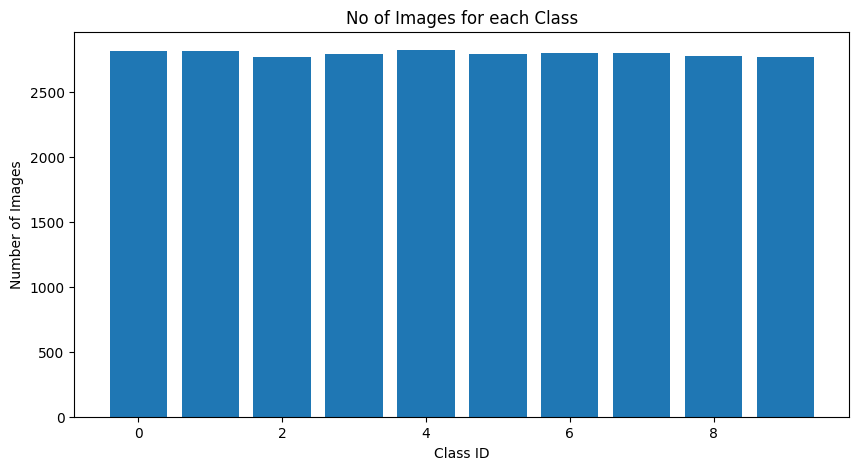

In [185]:
numOfSamples= []
for x in range(0,noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)
plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples)
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

#### PREPOSSESSING FUNCTION FOR IMAGES FOR TRAINING 

In [186]:
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img
    
def showImage(img, name='my-img'):
    plt.imshow(img,cmap='gray')
    plt.title(name)
    #plt.axis('off')
    plt.show()

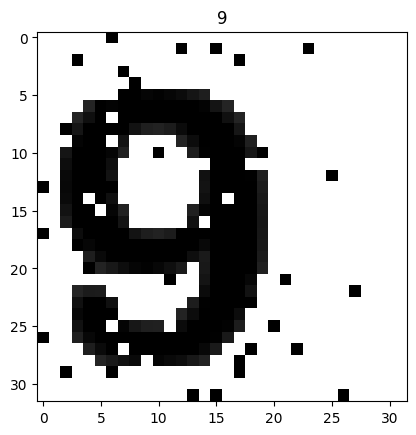

In [187]:
selectedImage=2000
img = preProcessing(X_train[selectedImage])
showImage(img, y_train[selectedImage]) 

#### preprocesss all images

In [188]:
X_train.shape

(27955, 32, 32, 3)

In [189]:
X_train= np.array(list(map(preProcessing,X_train)))
X_test= np.array(list(map(preProcessing,X_test)))
X_validation= np.array(list(map(preProcessing,X_validation)))

In [190]:
X_train.shape

(27955, 32, 32)

#### RESHAPE IMAGES 

In [191]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)

#### IMAGE AUGMENTATION 

In [192]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

#### ONE HOT ENCODING OF MATRICES

In [193]:
 ##### [0, 0, 1]]  # Correspond à la classe 2
y_train = to_categorical(y_train,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)


#### CREATING THE MODEL 

In [194]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500

    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(noOfNodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    #model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    return model
model = myModel()

In [195]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 12, 12, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_39 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 4, 4, 30)          0         
 ng2D)                                                

#### STARTING THE TRAINING PROCESS

In [196]:
len(X_train)//batchSizeVal


559

In [197]:
history = model.fit(dataGen.flow(X_train,y_train,
                                 batch_size=batchSizeVal),
                                 epochs=epochsVal,
                                 validation_data=(X_validation,y_validation),
                                 shuffle=1)


Epoch 1/10
560/560 [==============================] - 28s 50ms/step - loss: 0.7358 - accuracy: 0.7388 - val_loss: 0.0241 - val_accuracy: 0.9940
Epoch 2/10
560/560 [==============================] - 29s 52ms/step - loss: 0.1381 - accuracy: 0.9549 - val_loss: 0.0131 - val_accuracy: 0.9938
Epoch 3/10
560/560 [==============================] - 29s 52ms/step - loss: 0.0914 - accuracy: 0.9716 - val_loss: 0.0069 - val_accuracy: 0.9970
Epoch 4/10
560/560 [==============================] - 29s 52ms/step - loss: 0.0657 - accuracy: 0.9786 - val_loss: 0.0038 - val_accuracy: 0.9987
Epoch 5/10
560/560 [==============================] - 30s 53ms/step - loss: 0.0558 - accuracy: 0.9821 - val_loss: 0.0038 - val_accuracy: 0.9986
Epoch 6/10
560/560 [==============================] - 30s 53ms/step - loss: 0.0522 - accuracy: 0.9834 - val_loss: 0.0050 - val_accuracy: 0.9984
Epoch 7/10
560/560 [==============================] - 29s 52ms/step - loss: 0.0475 - accuracy: 0.9859 - val_loss: 0.0053 - val_accuracy:

#### PLOT THE RESULTS  

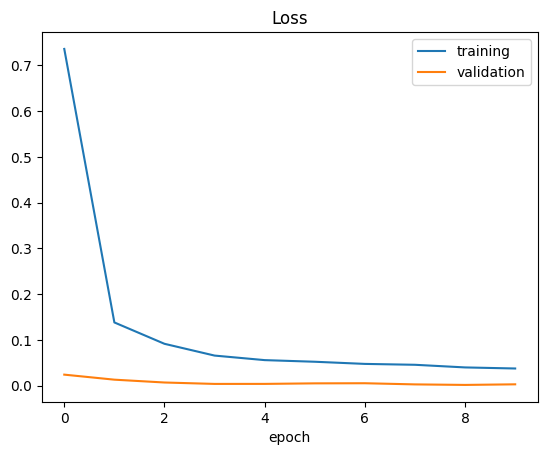

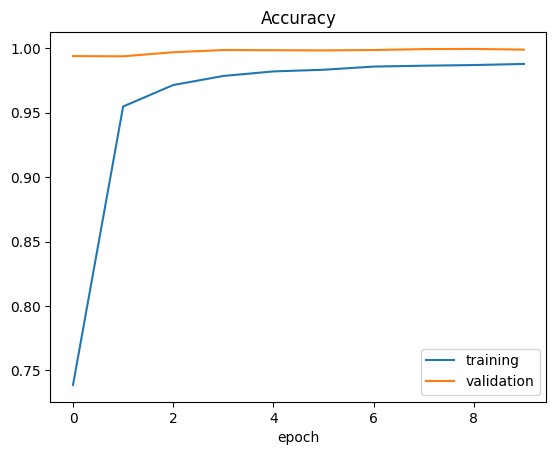

In [198]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

#### EVALUATE USING TEST IMAGES

In [199]:
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.00451204227283597
Test Accuracy = 0.9990842342376709


#### SAVE THE TRAINED MODEL 

In [200]:
pickle_out= open("model_trained.p", "wb")
pickle.dump(model,pickle_out)
pickle_out.close()

In [203]:
model.save('model_trained.keras')
